# Vibration-Based Condition Monitoring
## Varying Load Analysis — BCG & Computed Order Tracking

**Author:** Bradley Paul Nast  
**Module:** MEV781 — Vibration Based Condition Monitoring  
**University:** University of Pretoria  

---

This notebook covers fault diagnostics in a gearbox operating under **varying shaft speed** (~500–2000 RPM). Under varying speed conditions, classical FFT analysis is insufficient — gear mesh frequency components are smeared across frequency bands, making fault identification unreliable.

The pipeline addresses this through two stages:

1. **Bayesian Geometry Compensation (BCG)** — corrects shaft encoder imperfections to produce a clean, accurate RPM profile
2. **Computed Order Tracking (COT)** — resamples the vibration signal to the angular domain, eliminating speed-variation smearing and enabling reliable order spectrum analysis

Two signals are analysed — `signal_one` (frequency modulated only) and `signal_two` (frequency and amplitude modulated), allowing comparison of diagnostic performance under different modulation conditions.

---
## 0. Imports & Configuration

In [1]:
import numpy as np
import scipy as sp
import scipy.io as sio
import scipy.signal as sig
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import urllib.request
import io

# Plot styling
plt.rcParams.update({
    'figure.dpi': 120,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.size': 11
})

print('Libraries loaded.')

Libraries loaded.


---
## 1. Load Data & System Parameters

In [2]:
# ── Load .mat file from GitHub ────────────────────────────────────────────────
url = 'https://raw.githubusercontent.com/0xBPNast/data-science-portfolio/main/projects/condition-monitoring/data/mev_a2_q2_data.mat'

with urllib.request.urlopen(url) as response:
    data = sio.loadmat(io.BytesIO(response.read()))

# Extract vibration signals
signal_one = data['signal_one'].squeeze()   # FM only — frequency modulated
signal_two = data['signal_two'].squeeze()   # FM + AM — frequency & amplitude modulated

# Extract tachometer signals
tacho_one  = data['tacho_one'].squeeze()
tacho_two  = data['tacho_two'].squeeze()

# Extract sampling parameters
fs_vib   = data['Fs'].item()               # Vibration sampling frequency [Hz]
fs_tacho = data['Fs_tacho'].item()         # Tachometer sampling frequency [Hz]
PPR      = data['ppr'].item()              # Tachometer pulses per revolution

TRIGGER  = 1                               # Digital tachometer pulse value

print(f'Vibration Fs  : {fs_vib} Hz')
print(f'Tacho Fs      : {fs_tacho} Hz')
print(f'PPR           : {PPR}')
print(f'Signal length : {len(signal_one)} samples ({len(signal_one)/fs_vib:.2f} s)')
print(f'Tacho length  : {len(tacho_one)} samples ({len(tacho_one)/fs_tacho:.2f} s)')

Vibration Fs  : 25000 Hz
Tacho Fs      : 45000 Hz
PPR           : 60
Signal length : 250000 samples (10.00 s)
Tacho length  : 450000 samples (10.00 s)


In [3]:
# ── System parameters ─────────────────────────────────────────────────────────
n_teeth  = 30       # Number of gear teeth

# SKF 6206 bearing fault frequencies expressed as shaft order fractions
# (used for order domain analysis after COT)
GMF_order = n_teeth          # Gear mesh order = no. of teeth
BPOO      = 3.57             # Ball Pass Order, Outer Race

print(f'Gear mesh order : {GMF_order}')
print(f'BPOO            : {BPOO}')

Gear mesh order : 30
BPOO            : 3.57


---
## Part 1 — Shaft Speed Estimation & Bayesian Geometry Compensation (BCG)

Raw shaft speed estimation from a tachometer assumes all encoder segments are geometrically perfect. In practice, manufacturing imperfections cause unequal segment spacing, introducing spurious high-frequency spikes into the RPM profile.

**Bayesian Geometry Compensation (BCG)** estimates the true encoder segment spacing using Bayesian linear regression over multiple revolutions, correcting these imperfections and producing a smooth, accurate RPM profile.

In [4]:
import numpy.matlib as npml
from scipy.sparse.linalg import spsolve


def maketime(X, Fs):
    """
    Generate a time array for a signal of length X sampled at Fs.

    Parameters
    ----------
    X  : array — signal
    Fs : float — sampling frequency [Hz]

    Returns
    -------
    t : array — time array [s]
    """
    t0 = 0
    t1 = len(X) / Fs
    t  = np.arange(t0, t1 + 1 / Fs, 1 / Fs)
    return t


def PerformBayesianGeometryCompensation(t, N, M, e=[], beta=10.0e10, sigma=10.0):
    """
    Bayesian Geometry Compensation for shaft encoder imperfections.

    Estimates the true circumferential distances of encoder segments using
    Bayesian linear regression over M complete revolutions.

    Parameters
    ----------
    t     : array — zero crossing times (must have exactly M*N + 1 elements)
    N     : int   — number of encoder sections (PPR)
    M     : int   — number of complete revolutions
    e     : array — initial encoder geometry estimate (empty = assume equal)
    beta  : float — precision of likelihood function
    sigma : float — standard deviation of prior probability

    Returns
    -------
    epost : array — estimated circumferential distances for all N sections
    """
    if len(t) != M * N + 1:
        print('Input Error: t should contain exactly N*M + 1 values')
        raise SystemExit
    if len(e) != 0 and len(e) != N:
        print('Input Error: encoder input should be empty or length N')
        raise SystemExit

    # Build constraint matrices
    A = np.zeros((2 * M * N - 1, N + 2 * M * N))
    B = np.zeros((2 * M * N - 1, 1))
    T = np.ediff1d(t)   # Zero-crossing periods

    # Constraint: all segments sum to 2π
    A[0, :N] = np.ones(N)
    B[0, 0]  = 2 * np.pi

    # Continuity constraints (Eq. 9 & 10)
    for eq, coeff_e, coeff_t1, coeff_t2 in [
        (1,        3.0,  -0.5, -2.0),
        (M * N,    6.0,  -2.0, -6.0)
    ]:
        deduct = 0
        for m in range(M):
            if m == M - 1:
                deduct = 1
            for n in range(N - deduct):
                nm = m * N + n
                A[eq + nm - 1, n]               = coeff_e
                A[eq + nm - 1, N + nm * 2]      = coeff_t1 * T[nm] ** 2
                A[eq + nm - 1, N + nm * 2 + 1]  = coeff_t2 * T[nm]
                if eq == 1:
                    A[eq + nm - 1, N + (nm + 1) * 2 + 1] = -T[nm]
                else:
                    A[eq + nm - 1, N + (nm + 1) * 2]     = -T[nm] ** 2

    # Prior distribution
    m0     = np.zeros((N + 2 * M * N, 1))
    Sigma0 = np.identity(N + 2 * M * N) * sigma ** 2
    eprior = np.ones(N) * 2 * np.pi / N if len(e) == 0 else np.array(e) * 1.0
    m0[:N, 0] = eprior
    for m in range(M):
        for n in range(N):
            nm = m * N + n
            m0[N + nm * 2 + 1, 0] = m0[n, 0] / T[nm]

    # Bayesian posterior solve
    SigmaN = Sigma0 + beta * A.T.dot(A)
    BBayes = Sigma0.dot(m0) + beta * A.T.dot(B)
    mN     = np.array([spsolve(SigmaN, BBayes)]).T

    # Normalise to sum to 2π
    epost = mN[:N, 0] * 2 * np.pi / np.sum(mN[:N, 0])
    return epost


def getrpm(tacho, Fs, trig_level, slope, pprm, new_sample_freq):
    """
    Shaft RPM estimation with Bayesian Geometry Compensation.

    Estimates instantaneous shaft speed from a tachometer signal, correcting
    for encoder geometry imperfections via BCG.

    Parameters
    ----------
    tacho           : array — tachometer signal (1D)
    Fs              : float — tachometer sampling frequency [Hz]
    trig_level      : float — pulse trigger level
    slope           : int   — positive (1) or negative (-1) pulse slope
    pprm            : int   — pulses per revolution
    new_sample_freq : float — output RPM resampling frequency [Hz]

    Returns
    -------
    trpm          : array — RPM time array [s]
    rpm           : array — instantaneous RPM
    spacing_store : array — BCG-corrected encoder spacing
    """
    if type(tacho) == list:
        tacho = np.array(tacho)

    y  = np.sign(tacho - trig_level)
    dy = np.diff(y)
    tt = maketime(dy, Fs)

    # Detect pulse edges
    pos = np.nonzero(dy > 0.8) if slope > 0 else np.nonzero(dy < -0.8)
    yt  = tt[pos]
    dt  = np.diff(yt)
    dt  = np.hstack([dt, np.array([dt[-1]])])

    # Get tachometer zero-crossing times for BCG
    t_eval     = np.arange(0, len(dy) / Fs + 1 / Fs, 1 / Fs)
    cross_ind  = np.where(tacho == trig_level)[0]
    t_cross    = t_eval[cross_ind]
    n_revs     = int(len(cross_ind) / pprm)
    t_sections = t_cross[:n_revs * pprm + 1]

    # Run BCG to get corrected encoder spacing
    spacing_rev = PerformBayesianGeometryCompensation(
        t_sections, pprm, n_revs, e=[], beta=10.0e10, sigma=10.0
    )

    # Map BCG spacing back across full signal — reset counter at pprm (not hardcoded)
    spacing_store = np.zeros(len(dt))
    s_cnt = 0
    for i in range(len(dt) - 1):
        spacing_store[i] = spacing_rev[s_cnt]
        s_cnt = 0 if s_cnt == pprm - 1 else s_cnt + 1

    # Compute RPM from BCG-corrected spacing
    rpm = (60 / (2 * np.pi)) * (spacing_store / dt)

    # Smooth RPM
    b   = [0.25, 0.5, 0.25]
    rpm = sig.filtfilt(b, 1, rpm)

    # Resample RPM to uniform time grid
    N    = int(np.max(tt) * new_sample_freq + 1)
    trpm = np.linspace(0, np.max(tt), N)
    rpm  = np.interp(trpm, yt, rpm)

    # Remove NaN values
    valid = ~np.isnan(rpm)
    return trpm[valid], rpm[valid], spacing_store

In [5]:
# ── Run BCG RPM estimation for both signals ───────────────────────────────────
print('Running BCG for tacho_one...')
trpm_one, rpm_one, spacing_one = getrpm(
    tacho_one, fs_tacho, trig_level=TRIGGER, slope=1, pprm=PPR, new_sample_freq=fs_tacho
)

print('Running BCG for tacho_two...')
trpm_two, rpm_two, spacing_two = getrpm(
    tacho_two, fs_tacho, trig_level=TRIGGER, slope=1, pprm=PPR, new_sample_freq=fs_tacho
)

print(f'Signal one — RPM range: {rpm_one.min():.1f} – {rpm_one.max():.1f}')
print(f'Signal two — RPM range: {rpm_two.min():.1f} – {rpm_two.max():.1f}')

Running BCG for tacho_one...


C:\Users\Brad\AppData\Local\Temp\ipykernel_18188\3089489895.py:92: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  mN     = np.array([spsolve(SigmaN, BBayes)]).T


Running BCG for tacho_two...
Signal one — RPM range: 0.0 – 739.6
Signal two — RPM range: 0.0 – 1198.4


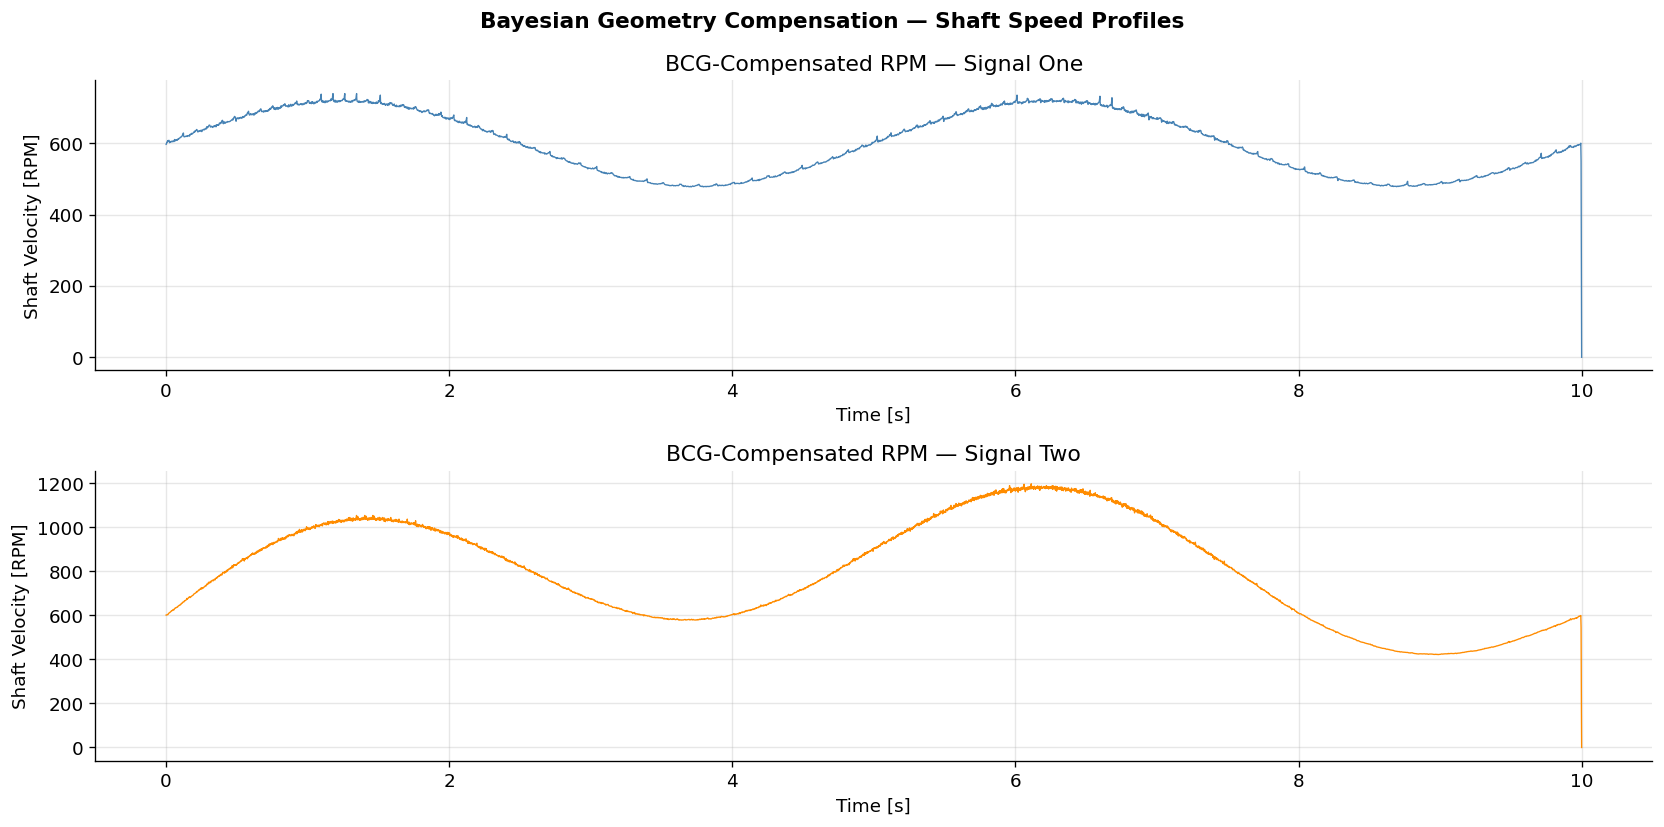

In [6]:
# ── Plot BCG RPM profiles ─────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=False)

axes[0].plot(trpm_one, rpm_one, color='steelblue', lw=0.8)
axes[0].set_title('BCG-Compensated RPM — Signal One')
axes[0].set_ylabel('Shaft Velocity [RPM]')
axes[0].set_xlabel('Time [s]')

axes[1].plot(trpm_two, rpm_two, color='darkorange', lw=0.8)
axes[1].set_title('BCG-Compensated RPM — Signal Two')
axes[1].set_ylabel('Shaft Velocity [RPM]')
axes[1].set_xlabel('Time [s]')

plt.suptitle('Bayesian Geometry Compensation — Shaft Speed Profiles',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### BCG Results

The BCG-compensated RPM profiles are significantly smoother than the raw tachometer-derived profiles. The abrupt spikes caused by unequal encoder segment spacing are eliminated, leaving only the genuine sinusoidal shaft speed variation.

- **Signal one** — pure frequency modulation, symmetric sinusoidal RPM variation
- **Signal two** — frequency and amplitude modulation, asymmetric RPM peaks

Note that RPM profiles moving toward zero at the signal boundaries are expected — BCG requires complete revolutions and discards incomplete ones at the edges.

---
## Part 2 — Computed Order Tracking (COT)

Under varying shaft speed, time-domain FFT analysis smears gear mesh frequency components across a band of frequencies (proportional to the speed variation range), making sidebands and fault harmonics difficult to identify.

**Computed Order Tracking (COT)** resamples the vibration signal from a uniform time basis to a uniform angular basis — equal samples per revolution regardless of shaft speed. This converts speed-varying frequency content into fixed order content, eliminating smearing entirely.

In [7]:
def cot(tach, Fs_tach, ppr, trigger, vibration, Fs_vibration, orders):
    """
    Computed Order Tracking (COT).

    Resamples a vibration signal from the time domain to the angular domain
    by interpolating a fixed number of samples per shaft revolution.
    Eliminates frequency smearing caused by varying shaft speed.

    Parameters
    ----------
    tach          : array — tachometer signal (1D)
    Fs_tach       : float — tachometer sampling frequency [Hz]
    ppr           : int   — tachometer pulses per revolution
    trigger       : float — tachometer pulse trigger value
    vibration     : array — vibration signal (1D)
    Fs_vibration  : float — vibration sampling frequency [Hz]
    orders        : int   — resampled points per revolution

    Returns
    -------
    t_cot   : array — resampled time array
    sig_cot : array — order-tracked vibration signal
    """
    # Tachometer time array
    N_tach  = np.size(tach)
    tf_tach = N_tach / Fs_tach
    t_tach  = np.linspace(0, tf_tach, N_tach)

    # Locate tachometer pulse indices
    pulse_ind = np.where(tach == trigger)[0]

    # Extract every PPRth pulse (one per revolution)
    N_windows = int(len(pulse_ind) / ppr)
    ppr_ind   = np.array([pulse_ind[ppr * i - 1] for i in range(1, N_windows + 1)])
    ppr_ind   = ppr_ind[ppr_ind != 0].astype(int)

    # Revolution boundary times from tachometer
    t_tach_ppr = t_tach[ppr_ind]

    # Vibration signal time array
    N_sig  = np.size(vibration)
    tf_sig = N_sig / Fs_vibration
    t_sig  = np.linspace(0, tf_sig, N_sig)

    # Map tachometer revolution boundaries to vibration signal indices
    # (vectorised — replaces slow linear seek loop)
    t_sig_ppr = np.array([t_sig[np.argmin(np.abs(t_sig - t))] for t in t_tach_ppr])
    t_sig_ind = np.array([np.where(t_sig == t)[0][0] for t in t_sig_ppr]).astype(int)

    # Interpolate fixed number of points between each revolution boundary
    t_cot   = []
    sig_cot = []

    for i in range(len(t_sig_ppr) - 1):
        t_start = t_sig[t_sig_ind[i]]
        t_end   = t_sig[t_sig_ind[i + 1]]
        t_rsmp  = np.linspace(t_start, t_end, orders)
        sig_int = np.interp(t_rsmp, t_sig, vibration)
        t_cot.append(t_rsmp)
        sig_cot.append(sig_int)

    t_cot   = np.array(t_cot).reshape(-1)
    sig_cot = np.array(sig_cot).reshape(-1)

    return t_cot, sig_cot

In [8]:
# ── Run COT for both signals ──────────────────────────────────────────────────
ORDERS = 2048    # Resampled points per revolution

print('Running COT for signal_one...')
t_cot_one, sig_cot_one = cot(
    tacho_one, fs_tacho, PPR, TRIGGER, signal_one, fs_vib, orders=ORDERS
)

print('Running COT for signal_two...')
t_cot_two, sig_cot_two = cot(
    tacho_two, fs_tacho, PPR, TRIGGER, signal_two, fs_vib, orders=ORDERS
)

print(f'COT signal one length: {len(sig_cot_one)} samples')
print(f'COT signal two length: {len(sig_cot_two)} samples')

Running COT for signal_one...
Running COT for signal_two...
COT signal one length: 200704 samples
COT signal two length: 270336 samples


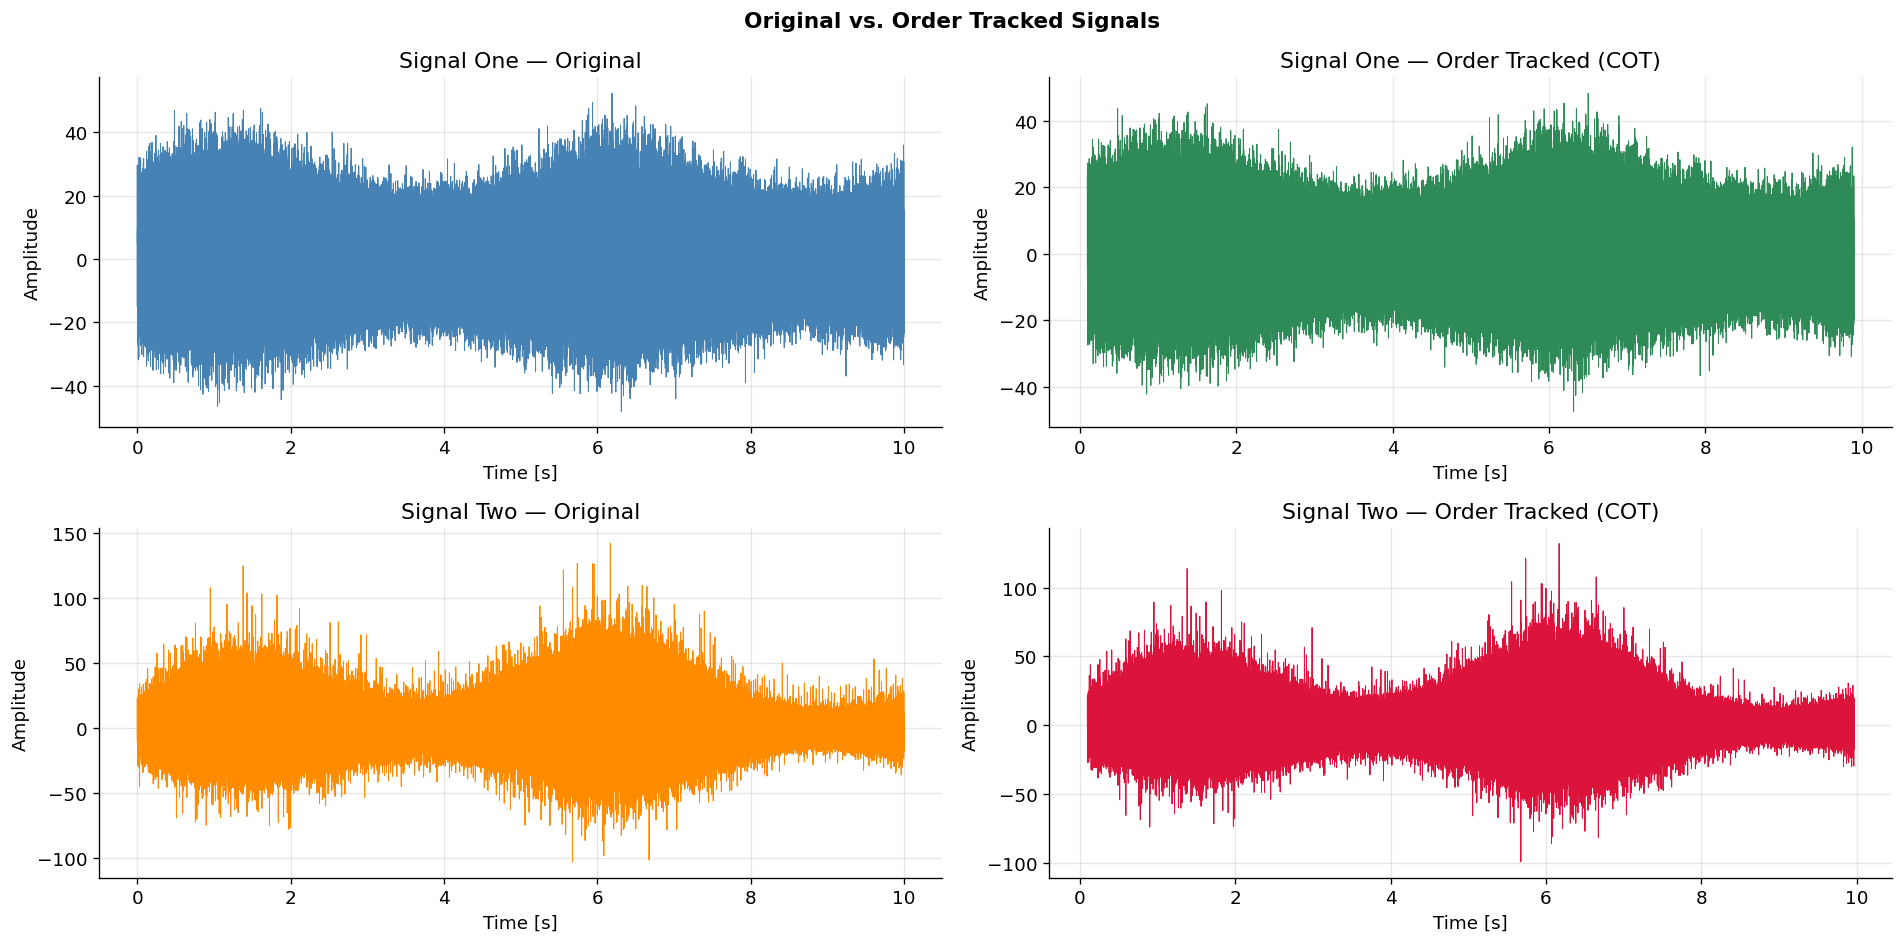

In [9]:
# ── Plot original vs COT signals ──────────────────────────────────────────────
t_vib_one = np.arange(len(signal_one)) / fs_vib
t_vib_two = np.arange(len(signal_two)) / fs_vib

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

axes[0, 0].plot(t_vib_one, signal_one, color='steelblue', lw=0.6)
axes[0, 0].set_title('Signal One — Original')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_xlabel('Time [s]')

axes[0, 1].plot(t_cot_one, sig_cot_one, color='seagreen', lw=0.6)
axes[0, 1].set_title('Signal One — Order Tracked (COT)')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_xlabel('Time [s]')

axes[1, 0].plot(t_vib_two, signal_two, color='darkorange', lw=0.6)
axes[1, 0].set_title('Signal Two — Original')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].set_xlabel('Time [s]')

axes[1, 1].plot(t_cot_two, sig_cot_two, color='crimson', lw=0.6)
axes[1, 1].set_title('Signal Two — Order Tracked (COT)')
axes[1, 1].set_ylabel('Amplitude')
axes[1, 1].set_xlabel('Time [s]')

plt.suptitle('Original vs. Order Tracked Signals', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Part 3 — Order Spectrum Analysis

In [10]:
def order_spectrum(sig_cot, orders):
    """
    Compute the order spectrum of a COT signal.

    Parameters
    ----------
    sig_cot : array — order-tracked vibration signal
    orders  : int   — resampled points per revolution

    Returns
    -------
    order_axis : array — order axis
    spectrum   : array — single-sided order spectrum magnitude
    """
    N        = len(sig_cot)
    spectrum = np.abs(fft(sig_cot)) / N
    # Convert frequency bins to order axis
    order_axis = np.arange(N) * orders / N
    # Single-sided
    half = N // 2
    return order_axis[:half], spectrum[:half]

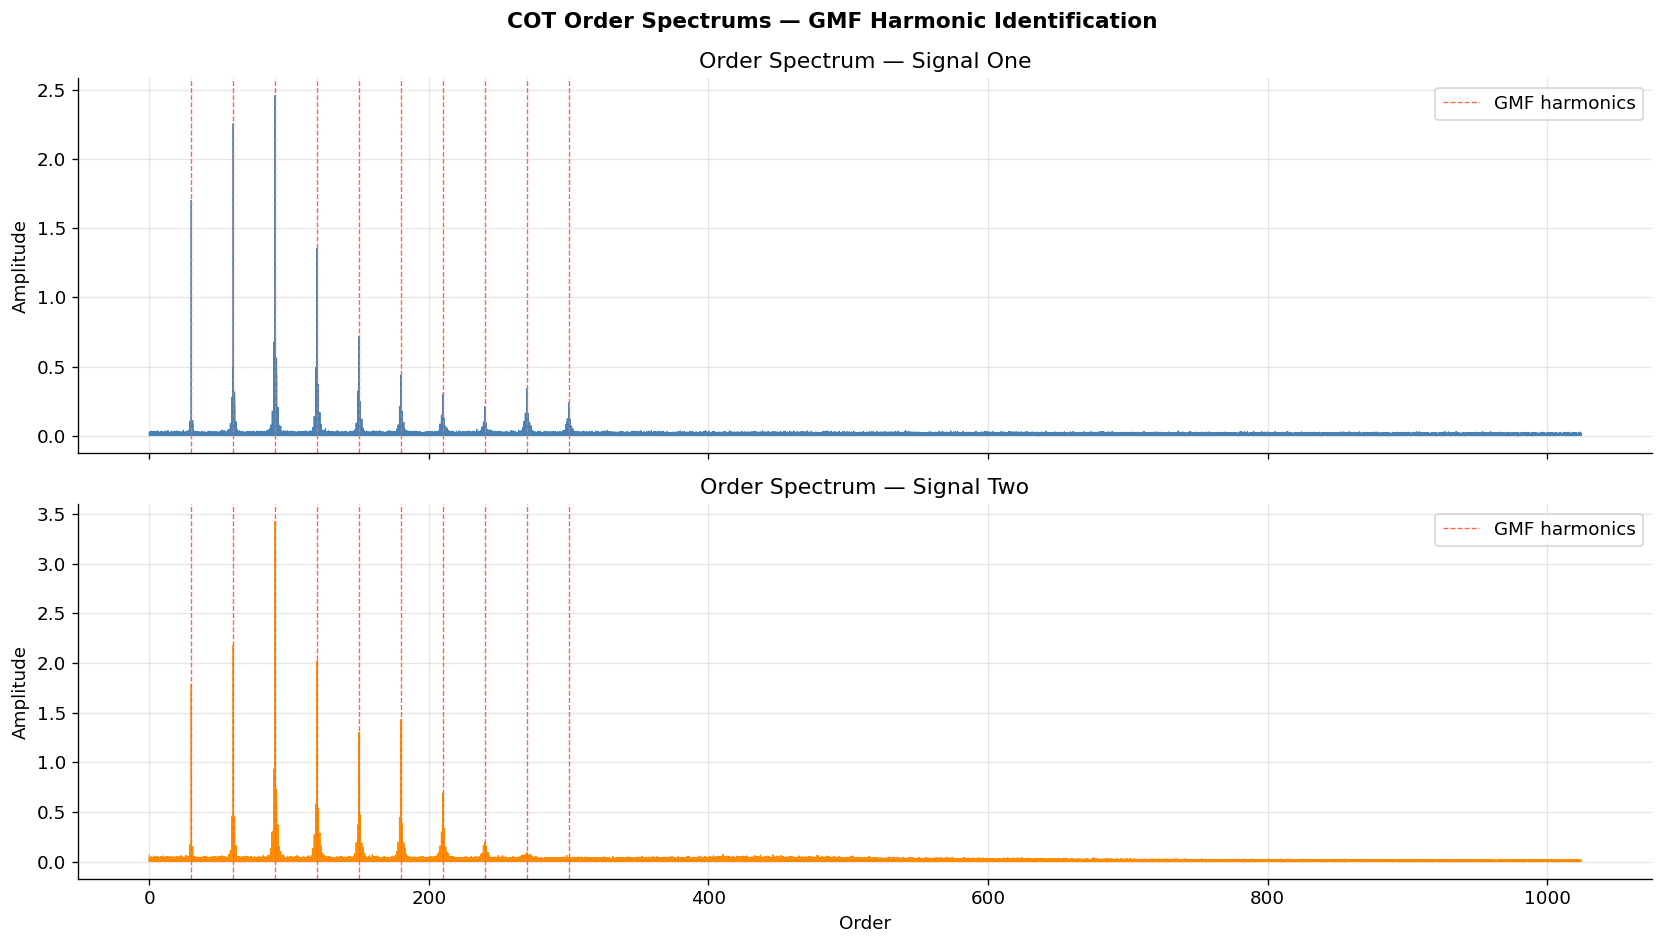

In [11]:
# ── Compute order spectrums ───────────────────────────────────────────────────
orders_one, spec_one = order_spectrum(sig_cot_one, ORDERS)
orders_two, spec_two = order_spectrum(sig_cot_two, ORDERS)

# ── Plot full order spectrums ─────────────────────────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(orders_one, spec_one, color='steelblue', lw=0.7)
for h in range(1, 11):
    axes[0].axvline(GMF_order * h, color='tomato', ls='--', lw=0.8,
                    label='GMF harmonics' if h == 1 else None)
axes[0].set_title('Order Spectrum — Signal One')
axes[0].set_ylabel('Amplitude')
axes[0].legend()

axes[1].plot(orders_two, spec_two, color='darkorange', lw=0.7)
for h in range(1, 11):
    axes[1].axvline(GMF_order * h, color='tomato', ls='--', lw=0.8,
                    label='GMF harmonics' if h == 1 else None)
axes[1].set_title('Order Spectrum — Signal Two')
axes[1].set_ylabel('Amplitude')
axes[1].set_xlabel('Order')
axes[1].legend()

plt.suptitle('COT Order Spectrums — GMF Harmonic Identification',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

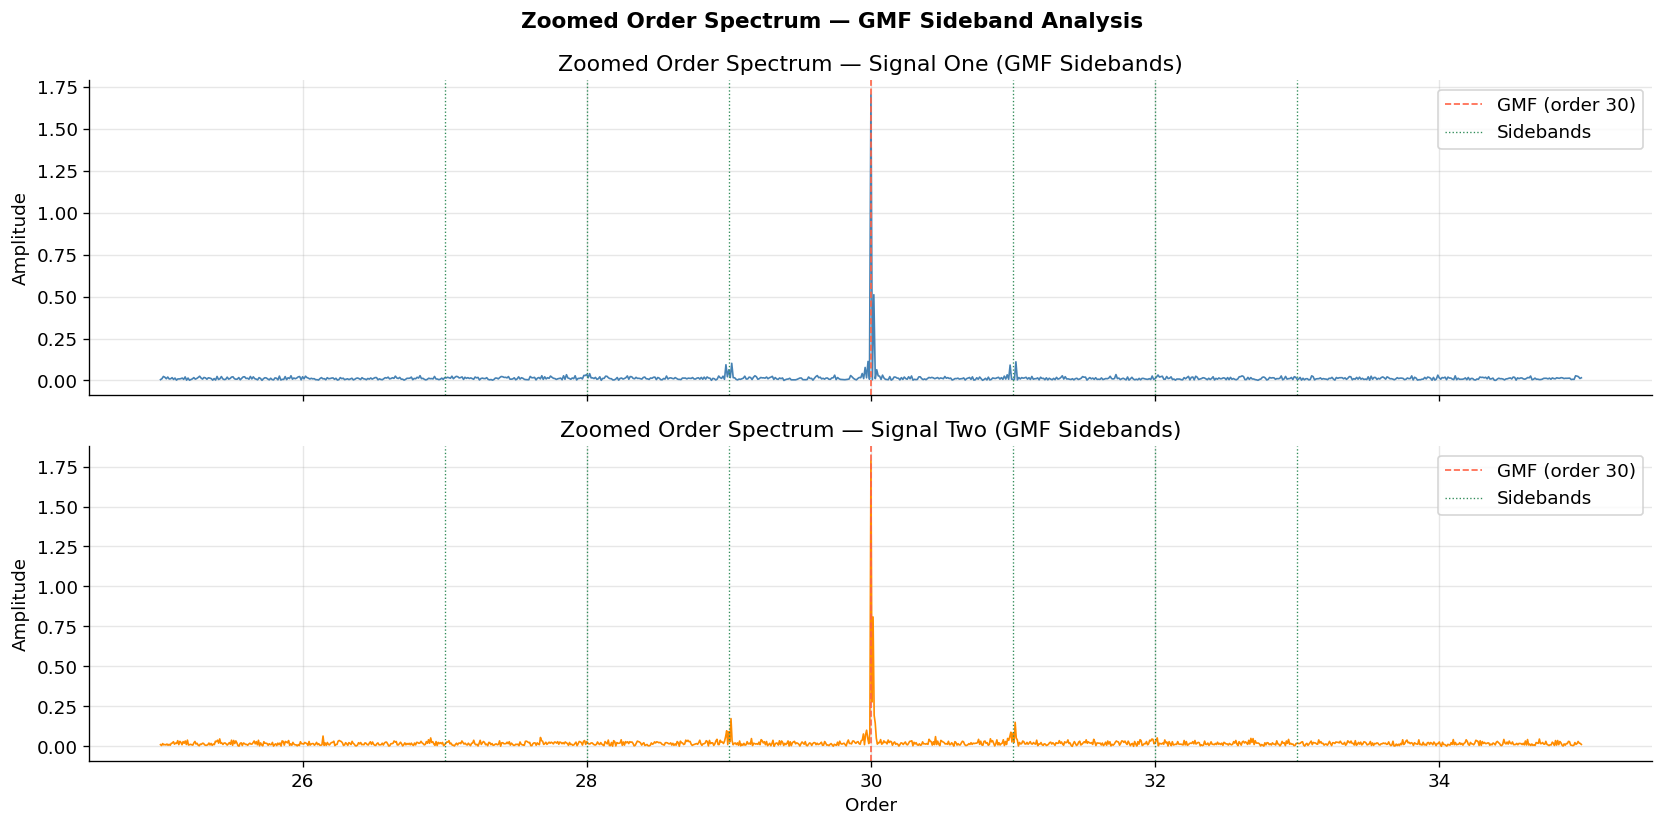

In [12]:
# ── Zoomed order spectrum — sidebands around GMF fundamental ──────────────────
ZOOM_LOW  = GMF_order - 5
ZOOM_HIGH = GMF_order + 5

mask_one = (orders_one >= ZOOM_LOW) & (orders_one <= ZOOM_HIGH)
mask_two = (orders_two >= ZOOM_LOW) & (orders_two <= ZOOM_HIGH)

fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

axes[0].plot(orders_one[mask_one], spec_one[mask_one], color='steelblue', lw=1.0)
axes[0].axvline(GMF_order, color='tomato',   ls='--', lw=1.0, label=f'GMF (order {GMF_order})')
for s in range(1, 4):
    axes[0].axvline(GMF_order - s, color='seagreen', ls=':', lw=0.8,
                    label='Sidebands' if s == 1 else None)
    axes[0].axvline(GMF_order + s, color='seagreen', ls=':', lw=0.8)
axes[0].set_title('Zoomed Order Spectrum — Signal One (GMF Sidebands)')
axes[0].set_ylabel('Amplitude')
axes[0].legend()

axes[1].plot(orders_two[mask_two], spec_two[mask_two], color='darkorange', lw=1.0)
axes[1].axvline(GMF_order, color='tomato',   ls='--', lw=1.0, label=f'GMF (order {GMF_order})')
for s in range(1, 4):
    axes[1].axvline(GMF_order - s, color='seagreen', ls=':', lw=0.8,
                    label='Sidebands' if s == 1 else None)
    axes[1].axvline(GMF_order + s, color='seagreen', ls=':', lw=0.8)
axes[1].set_title('Zoomed Order Spectrum — Signal Two (GMF Sidebands)')
axes[1].set_ylabel('Amplitude')
axes[1].set_xlabel('Order')
axes[1].legend()

plt.suptitle('Zoomed Order Spectrum — GMF Sideband Analysis',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

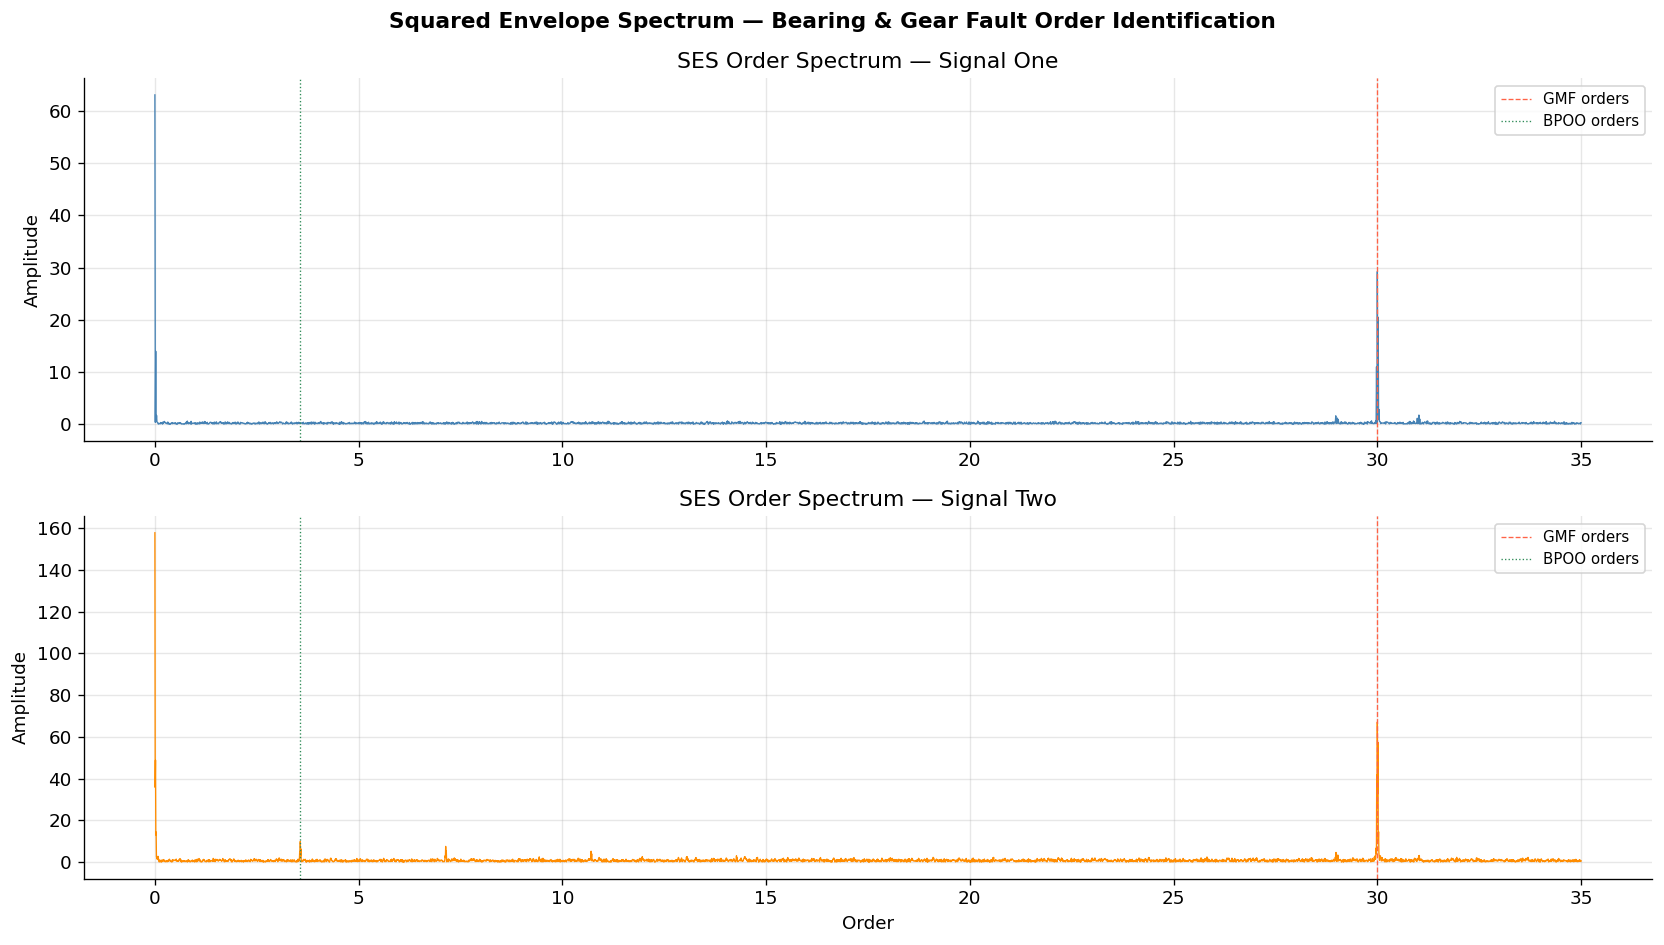

In [14]:
# ── Squared Envelope Spectrum (SES) in order domain ───────────────────────────
def order_ses(sig_cot, orders):
    """
    Squared Envelope Spectrum in the order domain.

    Applies Hilbert envelope extraction to the COT signal then
    computes the order spectrum of the squared envelope.

    Parameters
    ----------
    sig_cot : array — order-tracked vibration signal
    orders  : int   — resampled points per revolution

    Returns
    -------
    order_axis : array — order axis
    ses        : array — squared envelope order spectrum
    """
    from scipy.signal import hilbert
    envelope   = np.abs(hilbert(sig_cot))
    envelope  -= np.mean(envelope)
    N          = len(envelope)
    ses        = np.abs(fft(envelope ** 2)) / N
    order_axis = np.arange(N) * orders / N
    half       = N // 2
    return order_axis[:half], ses[:half]


ord_ses_one, ses_one = order_ses(sig_cot_one, ORDERS)
ord_ses_two, ses_two = order_ses(sig_cot_two, ORDERS)

# ── Plot SES — bearing fault order identification ─────────────────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for ax, ord_ax, ses, label, color in [
    (axes[0], ord_ses_one, ses_one, 'Signal One', 'steelblue'),
    (axes[1], ord_ses_two, ses_two, 'Signal Two', 'darkorange')
]:
    zoom = ord_ax <= GMF_order + 5
    ax.plot(ord_ax[zoom], ses[zoom], color=color, lw=0.8)
    for h in range(1, 2):
        ax.axvline(GMF_order * h, color='tomato', ls='--', lw=0.8,
                   label='GMF orders' if h == 1 else None)
        ax.axvline(BPOO * h, color='seagreen', ls=':', lw=0.8,
                   label='BPOO orders' if h == 1 else None)
    ax.set_title(f'SES Order Spectrum — {label}')
    ax.set_ylabel('Amplitude')
    ax.legend(fontsize=9)

axes[1].set_xlabel('Order')
plt.suptitle('Squared Envelope Spectrum — Bearing & Gear Fault Order Identification',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### Order Tracking Results

Following COT, fault orders are clearly identified in both signals:

- **GMF fundamental at order 30** with harmonics every 30 orders — consistent with 30 gear teeth
- **GMF sidebands at ±1 order intervals** around the fundamental — indicative of gear tooth modulation
- **BPOO at order 3.57** visible in the SES for signal two — bearing outer race fault present under amplitude-modulated conditions

**Comparison with signal one vs. signal two:**
- Signal one (FM only) produces cleaner, sharper order peaks with more visible harmonics
- Signal two (FM + AM) shows higher amplitude GMF content and additional BPOO orders due to the combined modulation effect

---

## Summary

This notebook demonstrates a complete order tracking pipeline for fault diagnosis under varying shaft speed. All functions are custom implementations.

| Step | Purpose | Output |
|---|---|---|
| BCG | Correct encoder geometry imperfections | Smooth RPM profile |
| COT | Resample to angular domain | `sig_cot` — order-tracked signal |
| Order Spectrum | Identify GMF and sidebands | Fixed order peaks, no smearing |
| SES | Identify bearing fault orders | BPOO and harmonics |

For the learning-based alternative to this pipeline using Hankel matrices and PCA health indicators, see **`03_learning_based_diagnostics.ipynb`**.